In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
import copy
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader
    
def T_scaling(logits, temperature):
  return torch.div(logits, temperature)

def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    #temperature = nn.Parameter(torch.ones(1) * temp_constant)
    #temperature = temperature.unsqueeze(1).expand(logits.size(0), logits.size(1)).cuda()
    #return F.cross_entropy(T_scaling(logits, temperature), y_batch).mean()
    return F.cross_entropy(logits, y_batch).mean()

In [2]:
transform = transforms.ToTensor()
batch_size=100

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.FashionMNIST('fashion-10', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('fashion-10', download=True, train=False, transform=transform)
print(trainset[0][0].shape)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Extracting fashion-10/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw
Processing...
Done!
torch.Size([1, 28, 28])


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [4]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)
    return lr_lambda

In [5]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=480, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits#, probs

In [13]:
import time
import copy

temps = [0.1, 2., 3.]
torch.cuda.empty_cache()
#resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
resnet18 = LeNet5(10)
cnt = 0
for el in resnet18.parameters():
  cnt += 1
print(cnt)
resnet18 = resnet18.cuda()

num_epochs = 21
start_lr = 0.01
end_lr = 0.1
factor = 10
#temperature = nn.Parameter(torch.ones(1).cuda())
#opt = torch.optim.LBFGS(list(resnet18.parameters()) + [temperature], lr=end_lr, max_iter=10000, line_search_fn='strong_wolfe')
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


step_size = 1*len(trainset) / batch_size
print(step_size)
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

models_list = []
weight_list = []
loss_list = []

train_loss = []
val_accuracy = []
losses = []
accs = []

lr_find_loss = []
learning_rates = []

it = 0

smoothing = 0.5
small_flag = False
lrs = []

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
        
        scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        learning_rates.append(lr_step)
        #print(lr_step)
        if lr_step <= 0.00103:
            #print('add minimun')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(10.)
            val_loss = 0.
            for (X_batch, y_batch) in testloader:
                val_loss += compute_loss(X_batch, y_batch)
            val_loss = val_loss.detach().cpu().numpy() * batch_size/ len(testloader.dataset)
            print('min', val_loss)
            loss_list.append(val_loss)
        elif lr_step <= 0.00502 and lr_step > 0.00499:
            #print('add not minimum')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(1.)
            val_loss = 0.
            for (X_batch, y_batch) in testloader:
                val_loss += compute_loss(X_batch, y_batch)
            val_loss = val_loss.detach().cpu().numpy() * batch_size/ len(testloader.dataset)
            print('not', val_loss)
            loss_list.append(val_loss)
        if len(models_list) > 25:
          models_list = models_list[-25:]
        it += 1
              

        resnet18.train(False)
        for (X_batch, y_batch) in testloader:
            y_batch = y_batch.cuda()
            logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
        cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


        
    if epoch % 5 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

10
600.0
min 2.2829217529296875
not 0.6136297607421874
not 0.6172234725952148
Epoch 1 of 21 took 421.079s
  training loss (in-iteration): 	0.654983
  validation accuracy: 			79.81 %
not 0.504972038269043
not 0.510474510192871
min 0.43026161193847656
min 0.4303824234008789
min 0.4304958343505859
not 0.4422633743286133
not 0.44869075775146483
not 0.4594776153564453
not 0.4582958221435547
min 0.41391185760498045
min 0.4136701202392578
min 0.41336402893066404
min 0.4130081558227539
not 0.4179527282714844
not 0.4174631881713867
not 0.41860500335693357
not 0.45151969909667966
not 0.45074150085449216
not 0.45262725830078127
min 0.4163528823852539
min 0.416634635925293
min 0.4168341827392578
Epoch 6 of 21 took 423.780s
  training loss (in-iteration): 	0.433397
  validation accuracy: 			84.92 %
min 0.41686283111572264
min 0.4172560882568359
not 0.4364751434326172
not 0.43692752838134763
not 0.4379956817626953
not 0.45787227630615235
not 0.46069610595703125
not 0.46572639465332033
min 0.41551624

In [15]:
original_loss_list = loss_list
original_loss_list

[2.2829217529296875,
 0.6136297607421874,
 0.6172234725952148,
 0.504972038269043,
 0.510474510192871,
 0.43026161193847656,
 0.4303824234008789,
 0.4304958343505859,
 0.4422633743286133,
 0.44869075775146483,
 0.4594776153564453,
 0.4582958221435547,
 0.41391185760498045,
 0.4136701202392578,
 0.41336402893066404,
 0.4130081558227539,
 0.4179527282714844,
 0.4174631881713867,
 0.41860500335693357,
 0.45151969909667966,
 0.45074150085449216,
 0.45262725830078127,
 0.4163528823852539,
 0.416634635925293,
 0.4168341827392578,
 0.41686283111572264,
 0.4172560882568359,
 0.4364751434326172,
 0.43692752838134763,
 0.4379956817626953,
 0.45787227630615235,
 0.46069610595703125,
 0.46572639465332033,
 0.415516242980957,
 0.41470649719238284,
 0.41412113189697264,
 0.4137237548828125,
 0.43375698089599607,
 0.4358334732055664,
 0.4716275405883789,
 0.470411491394043,
 0.40428417205810546,
 0.4040103530883789,
 0.4038429260253906,
 0.42289726257324217,
 0.4273667907714844,
 0.43238929748535154,

In [21]:
temps = [0.1, 1.5, 2., 2.5, 3., 5.]
#original_loss_list = loss_list
ens_accs = []
print(len(models_list))
for t in temps:
    temp_constant = t
    loss_list = np.array(original_loss_list[-len(models_list):])
    #weight_list = weight_list[-len(models_list):]
    #print(loss_list)
    for i in range(loss_list.shape[0]):
        loss_list[i] = np.exp(loss_list[i] / temp_constant)

    weights = loss_list#np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    #print(weights)
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0.1 Ensemble accuracy =  86.4 %
1.5 Ensemble accuracy =  86.5 %
2.0 Ensemble accuracy =  86.5 %
2.5 Ensemble accuracy =  86.5 %
3.0 Ensemble accuracy =  86.5 %
5.0 Ensemble accuracy =  86.5 %


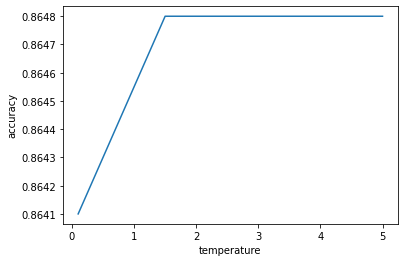

In [22]:
plt.plot(temps, ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

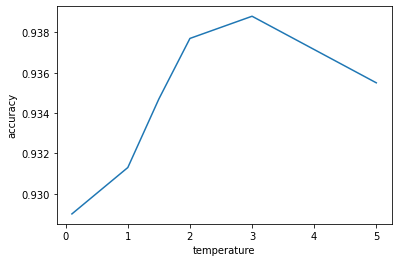

In [ ]:
small_ens_accs = ens_accs
plt.plot(temps, small_ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [17]:
def weigheted_most_common(predictions, weights):
    new_predictions = {}
    for i in range(len(predictions)):
        if predictions[i] in new_predictions:
            new_predictions[predictions[i]] = new_predictions[predictions[i]] + weights[i]
        else:
            new_predictions[predictions[i]] = weights[i]
    top = list(sorted(new_predictions.items(), key=lambda item: item[1], reverse=True))
    return top[0][0]
from collections import Counter
import numpy as np
def ensemble_predictions(members, loader, weights):
    accs = []
    for (X_batch, y_batch) in loader:
        yhats = []
        for model in members:
            y_batch = y_batch.cuda()
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            #print(y_pred.cpu().numpy())
            yhats.append(y_pred.cpu().numpy())
        yhats = np.array(yhats)
        maxs = []
        for i in range(yhats.shape[1]):
            cur_max = weigheted_most_common(yhats[:, i], weights)
            maxs.append(cur_max)
            #weighted_yhats = np.bincount(yhats[:, i], weights)
            #most_freq = np.argmax(weighted_yhats)
            #maxs.append(yhats[:, i][most_freq])
            #amounts = Counter(yhats[:, i])
            #most_freq = amounts.most_common(1)
            #maxs.append(most_freq[0][0])
        # sum across ensemble members
        maxs = np.array(maxs)
        # argmax across classes
        accs.append(np.mean((y_batch.cpu().numpy() == maxs)))
    accs = np.array(accs)
    return accs, np.mean(accs)

In [ ]:
weights = np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
print(round(mean_accs, 3) * 100, '%')

93.8 %


In [ ]:
import time
import copy

temps = [6., 10.]
#ens_accs = []

for t in temps:
    torch.cuda.empty_cache()
    print('Experiment for t = {}'.format(t))
    temp_constant = t
    resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
    resnet18 = resnet18.cuda()

    num_epochs = 21
    start_lr = 0.01
    end_lr = 0.1
    factor = 10
    temperature = nn.Parameter(torch.ones(1).cuda())
    #opt = torch.optim.LBFGS(list(resnet18.parameters()) + [temperature], lr=end_lr, max_iter=10000, line_search_fn='strong_wolfe')
    opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


    step_size = 1*len(trainset) / batch_size
    print(step_size)
    clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

    models_list = []
    weight_list = []
    loss_list = []

    train_loss = []
    val_accuracy = []
    losses = []
    accs = []

    lr_find_loss = []
    learning_rates = []

    it = 0

    smoothing = 0.5
    small_flag = False
    lrs = []

    for epoch in range(num_epochs):
        start_time = time.time()
        resnet18.train(True)
        for (X_batch, y_batch) in trainloader:
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            #print(loss.data.cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            
            scheduler.step()
            opt.zero_grad()

            lr_step = opt.state_dict()["param_groups"][0]["lr"]
            learning_rates.append(lr_step)
            #lr_find_loss.append(loss)
            if lr_step <= 0.00103:
                #print('add minimun')
                models_list.append(copy.deepcopy(resnet18))
                weight_list.append(10.)
                loss_list.append(loss)
            elif lr_step <= 0.00502 and lr_step > 0.00499:
                #print('add not minimum')
                models_list.append(copy.deepcopy(resnet18))
                weight_list.append(1.)
                loss_list.append(loss)
            if len(models_list) > 25:
              models_list = models_list[-25:]
            it += 1
            

        resnet18.train(False)
        for (X_batch, y_batch) in testloader:
            y_batch = y_batch.cuda()
            logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
        cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


        
        if epoch % 10 == 0:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(
                np.mean(train_loss[-len(trainset) // batch_size :])))
            print("  validation accuracy: \t\t\t{:.2f} %".format(
                np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())
    loss_list = np.array(loss_list[-len(models_list):])
    #weight_list = weight_list[-len(models_list):]
    for i in range(loss_list.shape[0]):
        loss_list[i] = loss_list[i].detach().cpu().numpy()
    weights = np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print('Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

Experiment for t = 6.0


RuntimeError: ignored

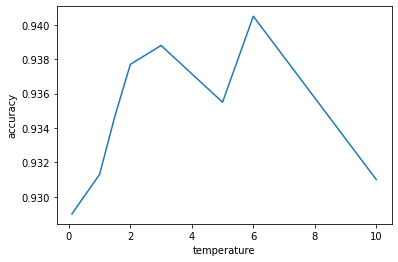

In [ ]:
plt.plot([0.1, 1., 1.5, 2., 3., 5., 6., 10.], ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()